#Zasoby

* Make predictions with PyTorch models in ONNX format

* https://cloud.google.com/bigquery/docs/e2e-journey
* https://cloud.google.com/bigquery/docs/making-predictions-with-pytorch-models-in-onnx-format
* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-onnx

#Cele

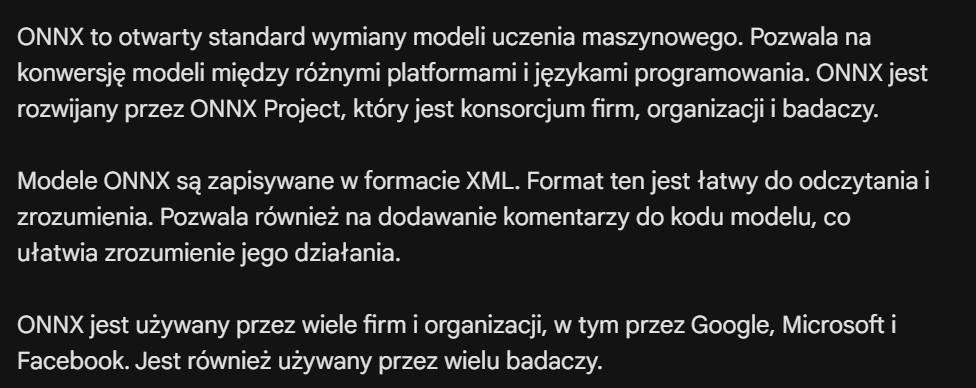

#Utwórz model wizji PyTorch do klasyfikacji obrazów (Krok 1)

* Zaimportuj wstępnie przeszkolony moduł `resnet18 PyTorch`, który akceptuje zdekodowane dane obrazu zwrócone przez technologię BigQuery ML `ML.DECODE_IMAGE i ML.RESIZE_IMAGE` funkcje.

In [1]:
import torch
import torch.nn as nn

# Define model input format to match the output format of
# ML.DECODE_IMAGE function: [height, width, channels]
dummy_input = torch.randn(1, 224, 224, 3, device="cpu")

# Load a pretrained pytorch model for image classification
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Reshape input format from [batch_size, height, width, channels]
# to [batch_size, channels, height, width]
class ReshapeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # reorder dimensions
        return x

class ArgMaxLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
       return torch.argmax(x, dim=1)

final_model = nn.Sequential(
    ReshapeLayer(),
    model,
    nn.Softmax(),
    ArgMaxLayer()
)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


#Przekonwertuj model do formatu ONNX i zapisz (Krok 2)

* Użyj pliku `torch.onnx`, aby wyeksportować model wizji PyTorch do pliku ONNX o nazwie `resnet18.onnx`.

In [3]:
pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 53.0 MB/s eta 0:00:00


In [4]:
torch.onnx.export(final_model,            # model being run
                  dummy_input,            # model input
                  "resnet18.onnx",        # where to save the model
                  opset_version=10,       # the ONNX version to export the model to
                  input_names = ['input'],         # the model's input names
                  output_names = ['class_label'])  # the model's output names


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



#Prześlij model ONNX do Cloud Storage (Krok 3)

In [ ]:
# gs://model_gcs/resnet18.onnx

#Zaimportuj model ONNX do BigQuery (Krok 4)

In [ ]:
%%bigquery

 CREATE OR REPLACE MODEL pmackowka_us.model_0181
  OPTIONS (MODEL_TYPE='ONNX',
   MODEL_PATH='gs://model_gcs/resnet18.onnx')

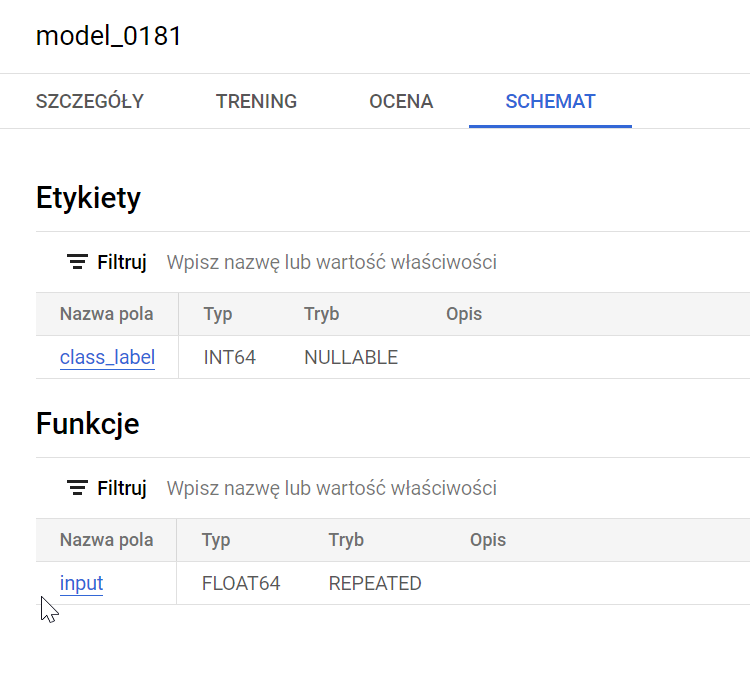

#Utwórz tabelę obiektów w BigQuery, aby uzyskać dostęp do danych obrazu (Krok 5)

* Aby uzyskać dostęp do nieustrukturyzowanych danych w BigQuery, musisz utworzyć tabelę obiektów https://cloud.google.com/bigquery/docs/object-tables#bq

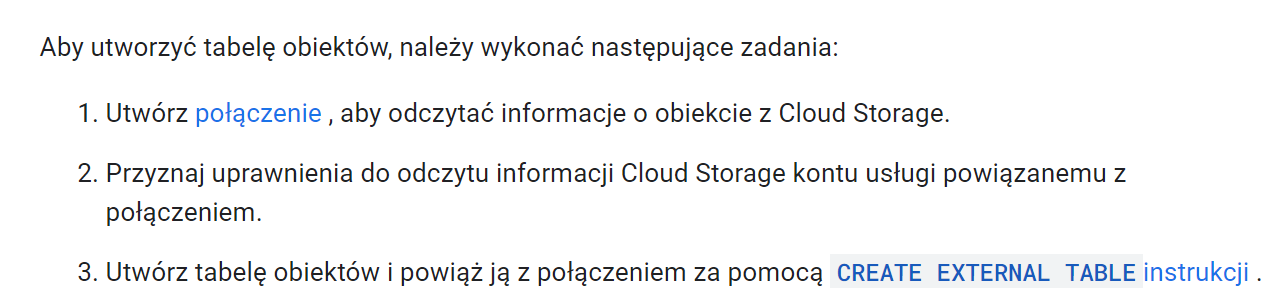

* Utwórz tabelę obiektów nazwaną `table_0181` na podstawie obrazu złotej rybki zapisanego w lokalizacji `gs://mybucket/goldfish.jpg`.

In [ ]:
%%bigquery

CREATE EXTERNAL TABLE `prj-ecom-p-ad-server-1077.pmackowka_us.table_0181`
WITH CONNECTION `us.biglake`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = ['gs://mybucket/goldfish.jpg'],
  max_staleness = INTERVAL 1 DAY,
  metadata_cache_mode = 'AUTOMATIC');

In [ ]:
%%bigquery

CREATE EXTERNAL TABLE `prj-ecom-p-ad-server-1077.pmackowka_us.table_0182`
WITH CONNECTION `us.biglake`
OPTIONS(
  object_metadata = 'SIMPLE',
  uris = ['gs://model_gcs/złota_rybka.jpg'],
  max_staleness = INTERVAL 1 DAY,
  metadata_cache_mode = 'AUTOMATIC');

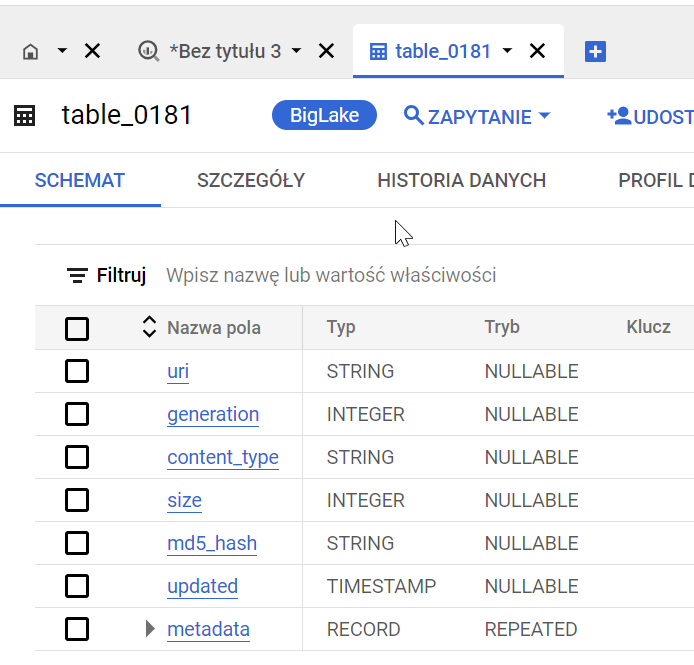

In [ ]:
%%bigquery

SELECT
  *
FROM
  `prj-ecom-p-ad-server-1077.pmackowka_us.table_0181`
LIMIT
  1000

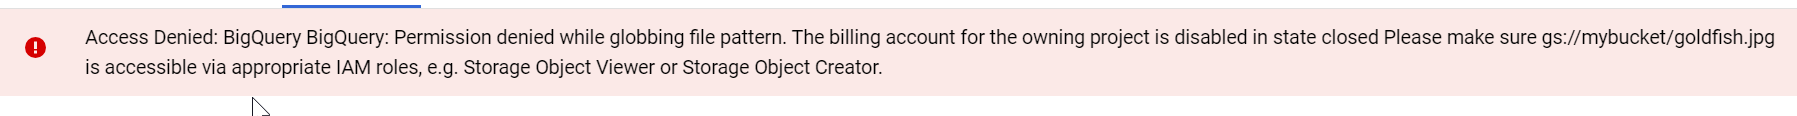

#Dokonuj prognoz za pomocą zaimportowanego modelu ONNX (Krok 6)

In [ ]:
%%bigquery

 SELECT
   class_label
 FROM
   ML.PREDICT(MODEL pmackowka_us.model_0181,
     (
     SELECT
       ML.RESIZE_IMAGE(ML.DECODE_IMAGE(DATA),
         224,
         224,
         FALSE) AS input
     FROM
       `prj-ecom-p-ad-server-1077.pmackowka_us.table_0181`) )